<a href="https://colab.research.google.com/github/alitheonly/PlantSeedling-/blob/main/Split_Sklearn_Train_Valid_VGG16_0128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c plant-seedlings-classification
!unzip plant-seedlings-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/ad12382d4.png      
  inflating: test/adb7a032c.png      
  inflating: test/ae90f2827.png      
  inflating: test/aecfaed64.png      
  inflating: test/aee6fa3df.png      
  inflating: test/af45e222a.png      
  inflating: test/afa446484.png      
  inflating: test/afcf6abd5.png      
  inflating: test/b026bf8ca.png      
  inflating: test/b03397525.png      
  inflating: test/b0acaff4a.png      
  inflating: test/b130a0632.png      
  inflating: test/b145ba9d4.png      
  inflating: test/b1cd2a91e.png      
  inflating: test/b215531dd.png      
  inflating: test/b2706e2b3.png      
  inflating: test/b29339405.png      
  inflating: test/b30ab4659.png      
  inflating: test/b31292706.png      
  inflating: test/b341d0aab.png      
  inflating: test/b39c71707.png      
  inflating: test/b3d6fdb80.png      
  inflating: test/b3e08b037.png      
  inflating: test/b47691c08.png      
  inflating: test/b4c3df835.png      

In [4]:

# Import necessary libraries
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
import tensorflow as tf
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import random
from glob import glob
import imageio

In [5]:
!ls ../content/train

 Black-grass	    'Common wheat'	'Scentless Mayweed'
 Charlock	    'Fat Hen'		'Shepherds Purse'
 Cleavers	    'Loose Silky-bent'	'Small-flowered Cranesbill'
'Common Chickweed'   Maize		'Sugar beet'


CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']

In [6]:
data_path = '/content/'
train_dir = os.path.join(data_path,'train')
test_dir = os.path.join(data_path, 'test')

train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'binary'])
train.head(2)
train.shape

In [7]:
images_path= '/content/train/*/*.png'
images = glob(images_path)

img_size = 224
train_images = []
train_labels = []
for i in images:
    train_images.append(cv2.resize(cv2.imread(i), (img_size, img_size))) 
    train_labels.append(i.split('/')[-2])
train_X = np.asarray(train_images)
train_Y = pd.DataFrame(train_labels)

In [8]:
train_X

array([[[[ 58,  73,  91],
         [ 49,  67,  90],
         [ 52,  72,  96],
         ...,
         [ 40,  52,  71],
         [ 42,  55,  72],
         [ 42,  54,  74]],

        [[ 52,  69,  88],
         [ 46,  67,  90],
         [ 45,  68,  93],
         ...,
         [ 38,  49,  71],
         [ 42,  54,  72],
         [ 38,  49,  69]],

        [[ 39,  64,  86],
         [ 36,  65,  89],
         [ 35,  63,  88],
         ...,
         [ 35,  47,  72],
         [ 40,  52,  74],
         [ 39,  51,  74]],

        ...,

        [[ 62,  81,  96],
         [ 58,  77,  93],
         [ 61,  78,  94],
         ...,
         [ 52,  70,  88],
         [ 52,  72,  89],
         [ 58,  77,  92]],

        [[ 64,  79,  95],
         [ 60,  76,  93],
         [ 62,  78,  93],
         ...,
         [ 63,  79,  95],
         [ 64,  80,  96],
         [ 64,  79,  95]],

        [[ 52,  63,  82],
         [ 55,  70,  86],
         [ 55,  70,  83],
         ...,
         [ 66,  83,  99],
        

In [9]:
train_Y

,0
0,Shepherds Purse
1,Shepherds Purse
2,Shepherds Purse
3,Shepherds Purse
4,Shepherds Purse
...,...
4745,Small-flowered Cranesbill
4746,Small-flowered Cranesbill
4747,Small-flowered Cranesbill
4748,Small-flowered Cranesbill


In [10]:
train_Y.rename(columns={0:'species'},inplace=True)
_, train_count = np.unique(train_Y,return_counts=True)
df = pd.DataFrame(data = train_count)
a = train_Y['species'].unique()
a = a.tolist()
a.sort()
df['Index'] = a
df.columns = ['Train','Name']
df

,Train,Name
0,263,Black-grass
1,390,Charlock
2,287,Cleavers
3,611,Common Chickweed
4,221,Common wheat
5,475,Fat Hen
6,654,Loose Silky-bent
7,221,Maize
8,516,Scentless Mayweed
9,231,Shepherds Purse


In [11]:
count=[]
plant=[]

In [12]:
for folder in sorted(os.listdir('/content/train')):
  #Takes length of all the image files combined, therefore returning count
  count.append(len(os.listdir('/content/train/'+folder)))
  #Creates a corresponding list of plant classes
  plant.append(folder)

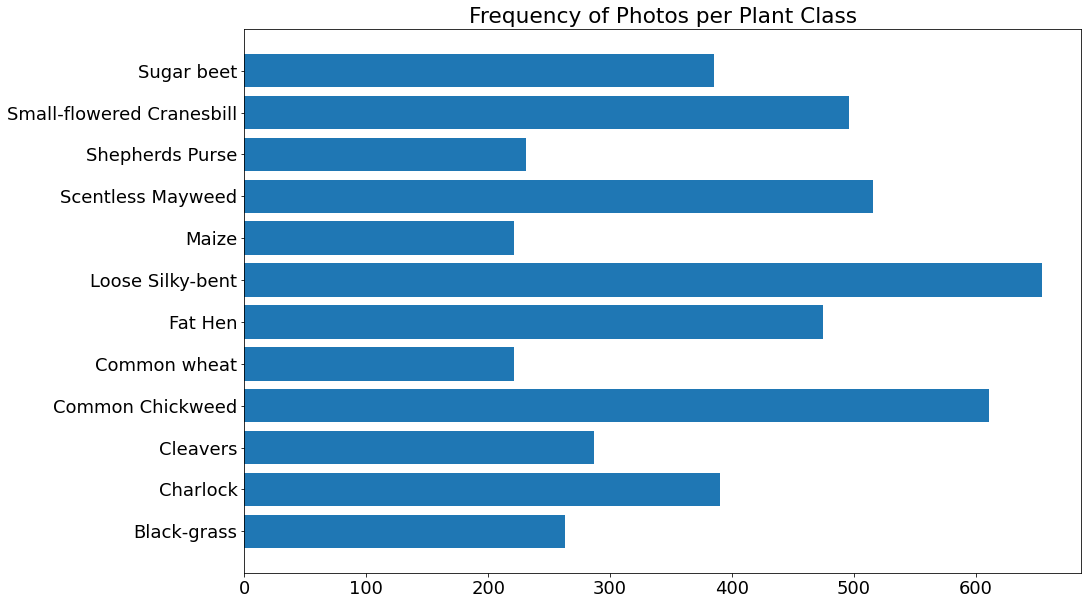

In [13]:
plt.rcParams.update({'font.size': 18})
fig,ax = plt.subplots(figsize=(15,10))
plt.barh(plant,count)
plt.title("Frequency of Photos per Plant Class")
plt.show()

In [14]:
plantdict = dict(zip(count, plant))
ordered = OrderedDict(sorted(plantdict.items()))


In [15]:
data=[0,1,2,3,4,5,6,7,8,9,10,11]
my_cmap = cm.get_cmap('jet')
my_norm = Normalize(vmin=0, vmax=12)

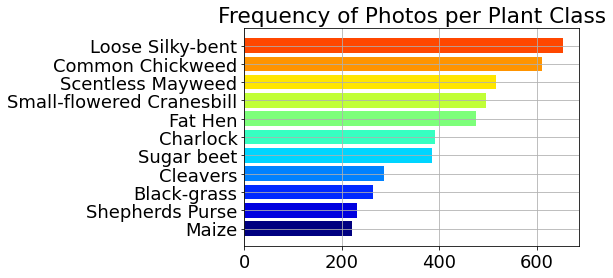

In [16]:
#Plotting horizontal bar plot with gird, colours and descending order of image count and respective plant classes
plt.barh(list(ordered.values()),list(ordered.keys()),color=my_cmap(my_norm(data)))
plt.title("Frequency of Photos per Plant Class")
plt.grid()
plt.show()

In [17]:
def plot_one_sample_of_each(base_path):
    cols = 4
    rows = int(np.ceil(len(plant) / 3))
    fig = plt.figure(figsize=(16, 20))
    
    for i in range(len(plant)):
        cls = plant[i]
        img_path = base_path + '/' + cls + '/**'
        path_contents = glob(img_path)
    
        imgs = random.sample(path_contents, 1)

        sp = plt.subplot(rows, cols, i + 1)
        plt.imshow(imageio.imread(imgs[0]))
        plt.title(cls)
        sp.axis('off')

    plt.show()

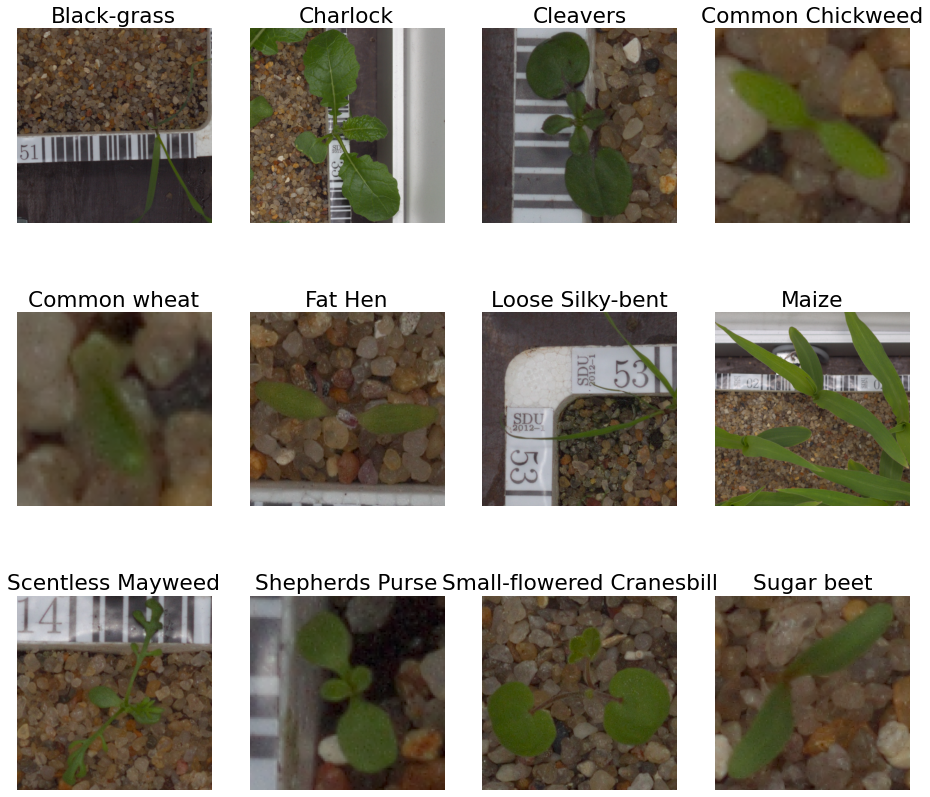

In [18]:
plot_one_sample_of_each(train_dir)

In [19]:
from sklearn.preprocessing import LabelBinarizer
y = LabelBinarizer().fit_transform(train_Y.species)
train_label = np.array(y,dtype=np.float32)
train_label

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [20]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_X, train_label,test_size=0.3,random_state=7)

Image Normalization

In [21]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255 

Image Data Generator

In [22]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=180,  
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True  
    )  
datagen.fit(train_X)

VGG Model

In [23]:
# Instantiate a VGG16 model with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))



58889256/58889256 [==============================] - 0s 0us/step


In [24]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [25]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [26]:
#Saving the best model using model checkpoint callback
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = tf.keras.callbacks.ModelCheckpoint('Split Sklearn Train/Valid VGG16.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose = 1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [29]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [30]:

# Train the model

history=model.fit(X_train, y_train , epochs=20, batch_size=32, validation_data=(X_test, y_test),callbacks = [early_stopping,checkpoint])

Epoch 1/20
104/104 [==============================] - ETA: 0s - loss: 2.0726 - accuracy: 0.3143
Epoch 1: val_accuracy improved from -inf to 0.34667, saving model to Split Sklearn Train/Valid VGG16.h5
104/104 [==============================] - 128s 1s/step - loss: 2.0726 - accuracy: 0.3143 - val_loss: 1.8312 - val_accuracy: 0.3467
Epoch 2/20
104/104 [==============================] - ETA: 0s - loss: 1.6766 - accuracy: 0.4385
Epoch 2: val_accuracy improved from 0.34667 to 0.48140, saving model to Split Sklearn Train/Valid VGG16.h5
104/104 [==============================] - 126s 1s/step - loss: 1.6766 - accuracy: 0.4385 - val_loss: 1.5533 - val_accuracy: 0.4814
Epoch 3/20
104/104 [==============================] - ETA: 0s - loss: 1.4811 - accuracy: 0.5041
Epoch 3: val_accuracy improved from 0.48140 to 0.51649, saving model to Split Sklearn Train/Valid VGG16.h5
104/104 [==============================] - 125s 1s/step - loss: 1.4811 - accuracy: 0.5041 - val_loss: 1.4246 - val_accuracy: 0.516

In [32]:
print(os.path.getsize("Split Sklearn Train/Valid VGG16.h5")/1048576, "MB")

62.369102478027344 MB


In [ ]:
from google.colab import files
# model.save('Split Sklearn Train/Valid VGG16.h5')
files.download('Split Sklearn Train/Valid VGG16.h5')

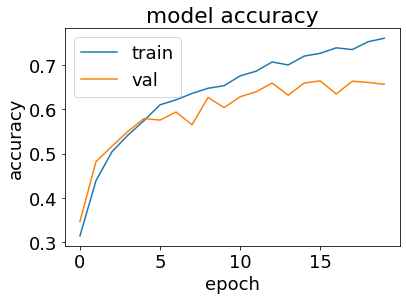

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

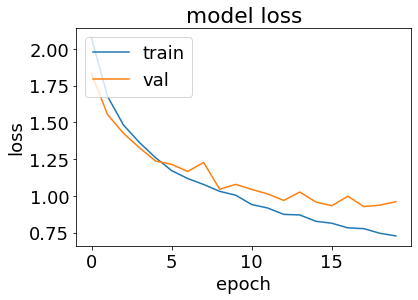

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [35]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)

104/104 [==============================] - 89s 858ms/step - loss: 0.7285 - accuracy: 0.7519
Test loss: 0.9599938988685608    Test accuracy: 0.6561403274536133
Train loss: 0.7284858226776123    Train accuracy: 0.7518796920776367


Predict train model

In [36]:
predictions = model.predict(X_test)

45/45 [==============================] - 38s 846ms/step


In [37]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = np.argmax(true_label[i]), img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% \n({})".format(np.array(df.Name)[predicted_label],
                                100*np.max(predictions_array),
                                np.array(df.Name)[true_label]),
                                color=color)

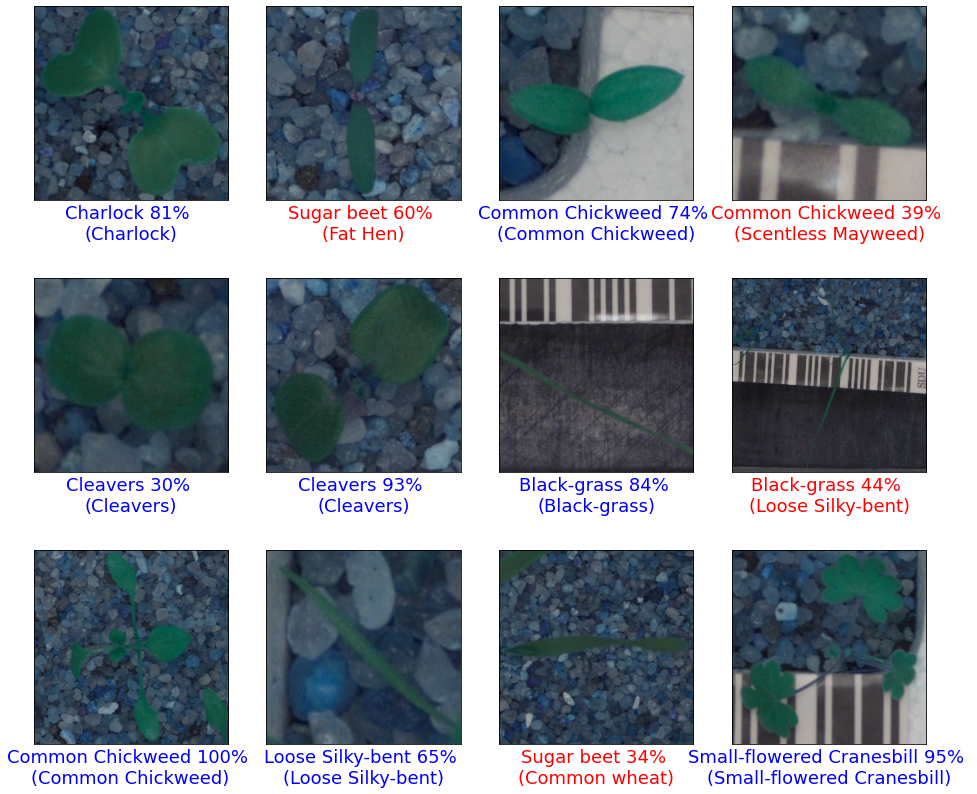

In [38]:
fig=plt.figure(figsize=(16, 20))
rows, cols = 3,4
for i in range(0, cols*rows):
    fig.add_subplot(rows, cols, i+1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplots_adjust(hspace=-0.5)
plt.show()

Predict Test Data

In [39]:
test_images_path = '/content/test/*.png'
test_images = glob(test_images_path)
test_images_arr = []
test_files = []

for img in test_images:
    test_images_arr.append(cv2.resize(cv2.imread(img), (224, 224)))
    test_files.append(img.split('/')[-1])

test_X = np.asarray(test_images_arr)

In [40]:
predictions = model.predict(test_X)
preds = np.argmax(predictions, axis=1)
pred_str = np.array(df.Name)[preds]
final_predictions = {'file':test_files, 'species':pred_str}
final_predictions = pd.DataFrame(final_predictions)
final_predictions

25/25 [==============================] - 21s 850ms/step


,file,species
0,56a01b835.png,Common Chickweed
1,03566743d.png,Common Chickweed
2,490c4f9c8.png,Common Chickweed
3,5e6a237f2.png,Common Chickweed
4,963544aa0.png,Common Chickweed
...,...,...
789,a55d26a4c.png,Common Chickweed
790,93d76fd5d.png,Common Chickweed
791,bb20fce02.png,Common Chickweed
792,1312065a5.png,Common Chickweed


In [41]:
final_predictions.to_csv("Plant-Seedlings-Classification.csv", index=False)

In [42]:
from google.colab import files
files.download('Plant-Seedlings-Classification.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

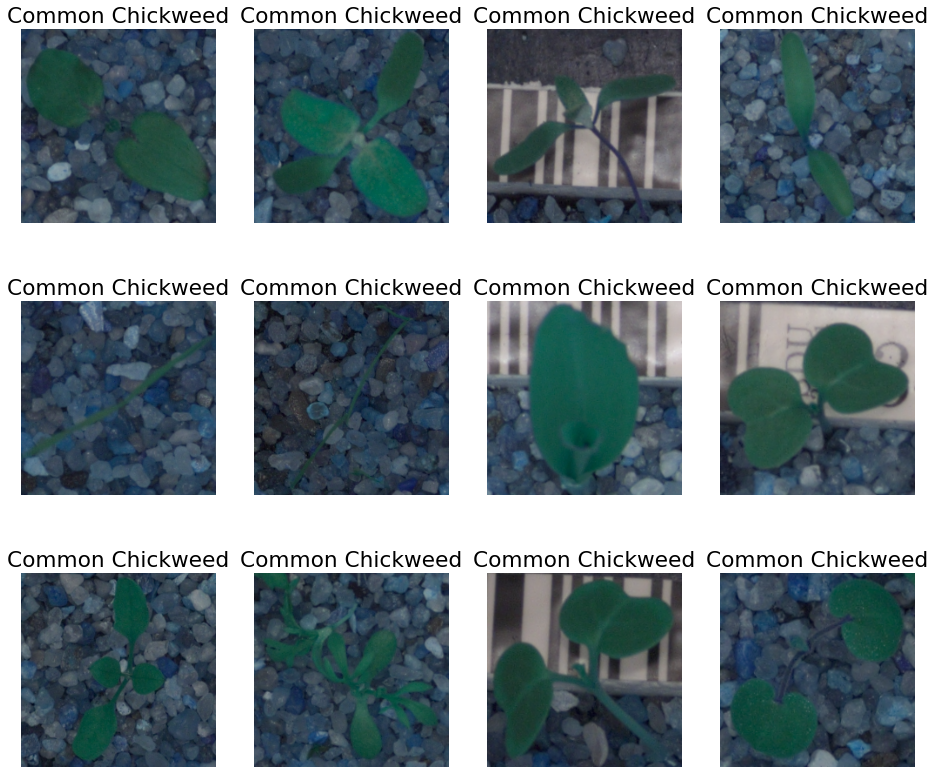

In [43]:
fig=plt.figure(figsize=(16, 20))
rows, cols = 3,4
for i in range(0, cols*rows):
    fig.add_subplot(rows, cols, i+1)
    plt.title(final_predictions.species[i])
    plt.imshow(test_X[i])
    plt.axis('off')
    plt.subplots_adjust(hspace= - 0.5)
    
plt.show()